In [14]:
from skopt.learning import ExtraTreesRegressor as opt_ETR
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [9]:
data = pd.read_csv("data/proposed.csv")
feat = data.loc[:, 'Li':'Contact time, s']
target = data.loc[:,'Y(C2), %']

for i in range(8):
    feat = feat.drop([f'{i+1}_AW', f'{i+1}_atomic radius', f'{i+1}_m. p.', f'{i+1}_b. p.', f'{i+1}_ionization enegy'], axis = 1)
    
conv = list(feat.loc[:, 'Li':'Bi'].columns) + list(feat.loc[:,'Promotor_Cl':'Contact time, s'].columns) 
swed_3 = list(feat.loc[:,'1_electronegativity':'Contact time, s'].columns) 

cand = pd.read_csv("data/clus_high.csv")


def EI(mu, sigma, cur_max):
    """
    EIの計算(鈴木氏作成)
    """
    Z = (mu - cur_max)/ sigma
    ei = (mu - cur_max) * norm.cdf(Z) + sigma*norm.pdf(Z)
    return ei

## ETR, SWED 3

In [29]:
model = opt_ETR(n_estimators = 500, n_jobs = -1, random_state = 1126)
model.fit(feat.loc[:, swed_3], target)

ExtraTreesRegressor(n_estimators=500, n_jobs=-1, random_state=1126)

In [5]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(clus_high.loc[:, swed_3])

In [48]:
def get_cellcol(v):
    return 'mistyrose' if v > 0 else 'lightcyan'

def plot_topshap(feat, base_val, k=10, figsize=None, save=None, title_name = None):

    figsize = figsize if figsize else (15, int(np.round(k/2)))
    fig, ax = plt.subplots(figsize=figsize)

    idx = feat['shap'].abs().argsort()[::-1]
    
    topk = idx[:k]
    other = idx[k:]
    
    shap = feat['shap'].iloc[topk]
    shap_cumsum = feat['shap'].iloc[other].sum()
    
    val = feat['val'].iloc[topk]
    feat_name = list(val.index)
    
    data = np.array([feat_name, val.round(3), shap.round(3)]).T
    col = ["feature name", "feat val", "SHAP val"]
    row = np.arange(1, len(data)+1)
    cellcol = np.array([['w']*k, ['w']*k, [get_cellcol(v) for v in shap]]).T
    w = 0.8

    s = base_val
    ax.text(s, k + 1.0 + 0.2, f'{s:1.3f}', ha='center', color='gray')
    ax.text(s, k + 1.0 - 0.2, 'base val', ha='center', color='gray')
    ax.axvline(s, linestyle='--', color='gray')

    s += shap_cumsum
    for i in range(k):
        delta = shap[k-i-1]
        arcol = 'tab:red' if delta > 0 else 'tab:blue'
        ax.arrow(x=s, y=i+1, dx=delta, dy=0,
                 width=0.4, head_width=0.6, head_length=0.01,
                 length_includes_head=True, color=arcol)
        s += delta
    ax.axvline(s, linestyle='--', color='b')
    ax.text(s, k + 1.0 + 0.2, f'{s:1.3f}', ha='center', va='center', color='b')
    ax.text(s, k + 1.0 - 0.2, 'predicted val', ha='center', va='center', color='b')
    ax.set_xlabel('model output value')

    inc = s - base_val
    ax.set_xlim(base_val - 1.0*inc, s + 0.2*inc)
    ax.set_ylim(0.5, k+0.5)

    the_table = ax.table(cellText=data,
                         rowLabels=row,
                         colLabels=col,
                         cellLoc='center',
                         colWidths=[2/3, 1/6, 1/6],
                         cellColours=cellcol,
                         bbox=(-0.8, 0.0, 0.8, (k+1) / k))

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(12)
    fig.canvas.draw()   # need to draw the figure twice

    plt.yticks([])
    plt.tight_layout()
    
    if title_name is not None:
        print(title_name)
    
    if save:
        plt.savefig(save)
    plt.show()

In [56]:
def get_cellcol(v):
    return 'mistyrose' if v > 0 else 'lightcyan'

def plot_topshap(feat, base_val, k=10, figsize=None, save=None, title_name = None):

    figsize = figsize if figsize else (15, int(np.round(k/2)))
    fig, ax = plt.subplots(figsize=figsize)

    idx = feat['shap'].abs().argsort()[::-1]
    
    topk = idx[:k]
    other = idx[k:]
    
    shap = feat['shap'].iloc[topk]
    shap_cumsum = feat['shap'].iloc[other].sum()
    
    val = feat['val'].iloc[topk]
    feat_name = list(val.index)

    
    data = np.array([feat_name, val.round(3), shap.round(3)]).T
    col = ["feat", "feat val", "SHAP val"]
    row = np.arange(1, len(data)+1)
    cellcol = np.array([['w']*k, ['w']*k, [get_cellcol(v) for v in shap]]).T
    w = 0.8

    s = base_val
    ax.text(s, k + 1.0 + 0.2, f'{s:1.3f}', ha='center', color='gray')
    ax.text(s, k + 1.0 - 0.2, 'base val', ha='center', color='gray')
    ax.axvline(s, linestyle='--', color='gray')

    s += shap_cumsum
    for i in range(k):
        delta = shap[k-i-1]
        arcol = 'tab:red' if delta > 0 else 'tab:blue'
        ax.arrow(x=s, y=i+1, dx=delta, dy=0,
                 width=0.4, head_width=0.6, head_length=0.2,
                 length_includes_head=True, color=arcol)
        s += delta
    ax.axvline(s, linestyle='--', color='b')
    ax.text(s, k + 1.0 + 0.2, f'{s:1.3f}', ha='center', va='center', color='b')
    ax.text(s, k + 1.0 - 0.2, 'predicted val', ha='center', va='center', color='b')
    ax.set_xlabel('model output value')

    inc = s - base_val
    ax.set_xlim(base_val - 0.1*inc, s + 0.1*inc)
    ax.set_ylim(0.5, k+0.5)

    the_table = ax.table(cellText=data,
                         rowLabels=row,
                         colLabels=col,
                         cellLoc='center',
                         colWidths=[2/3, 1/6, 1/6],
                         cellColours=cellcol,
                         bbox=(-0.8, 0.0, 0.8, (k+1) / k))

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(12)
    fig.canvas.draw()   # need to draw the figure twice

    plt.yticks([])
    plt.tight_layout()
    
    if title_name is not None:
        print(title_name)
    
    if save:
        plt.savefig(save)

In [57]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(cand.loc[:, swed_3])
base_val = target.mean()

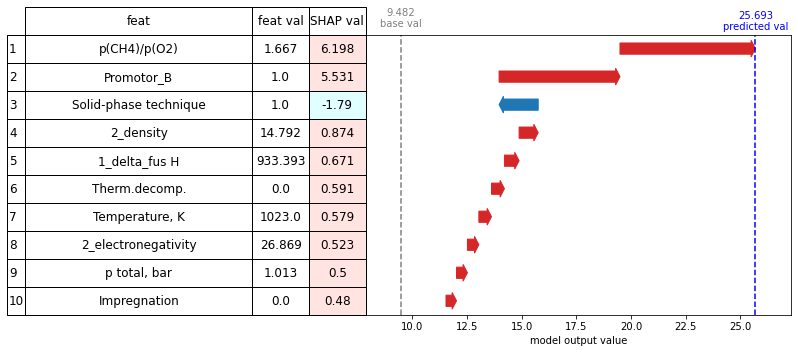

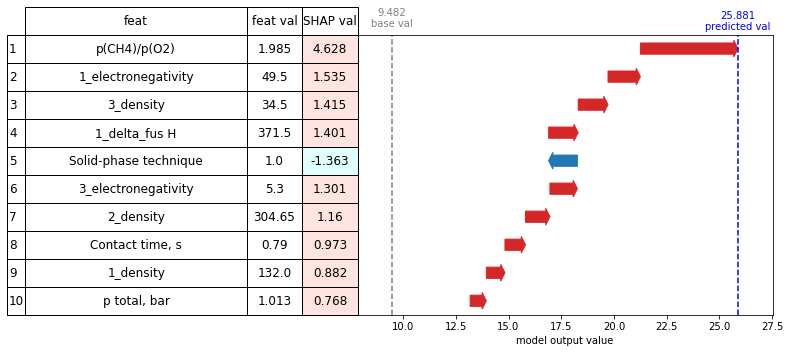

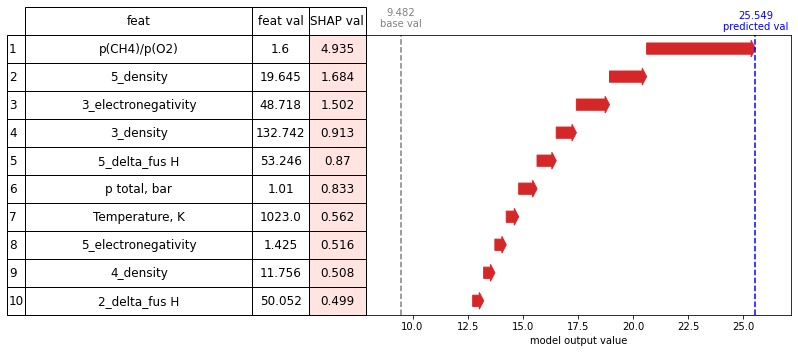

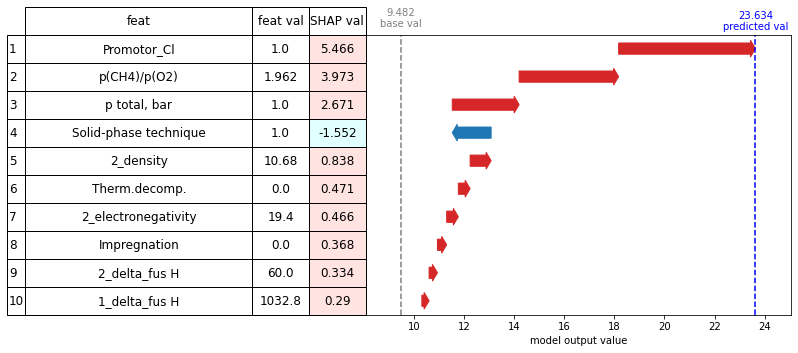

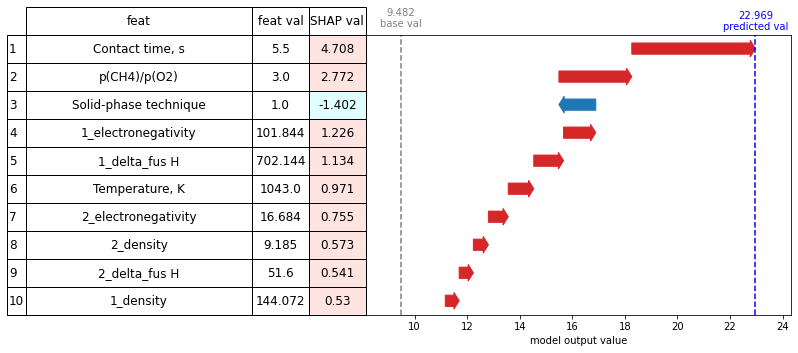

In [58]:
PATH = 'shap/'
import os 
os.makedirs(PATH, exist_ok = True)
for i in range(5):
    cand_name = cand.index[i]
    tmp = cand.loc[i, swed_3].astype('float').to_frame()
    tmp.columns = ['val']
    tmp['shap'] = shap_values[i]
    plot_topshap(tmp, base_val, k=10, figsize = (17, 5))
    plt.savefig(PATH + f'shap_{i}.svg', bbox_inches = 'tight', dpi = 100)

In [48]:
shap.force_plot(explainer.expected_value, shap_values[0,:], clus_high.loc[0,swed_3])

## Conventionl

In [49]:
model = opt_ETR(n_estimators = 500, n_jobs = -1, random_state = 1126)
model.fit(feat.loc[:, conv], target)

ExtraTreesRegressor(n_estimators=500, n_jobs=-1, random_state=1126)

In [50]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(clus_high.loc[:, conv])

In [51]:
shap.force_plot(explainer.expected_value, shap_values[0,:], clus_high.loc[0,conv])